# 데이콘 Basic 전화 해지 여부 분류 AI 경진대회

In [132]:
#기본
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#전처리
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from imblearn.under_sampling import RandomUnderSampler
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.decomposition import PCA

#학습
import xgboost as xgb
import lightgbm as lgbm
from sklearn.metrics import f1_score

#기타
import plotly.express as px


In [133]:
# os.chdir('./Data/전화해지')
print(os.getcwd())

c:\Users\movem\Documents\Python Scripts\Data\전화해지


In [134]:
def shownull(df):
    global missval_name
    print(f"데이터셋 차원 확인 \n {df.shape}")
    missval = df.isnull().sum()[df.isnull().sum()!=0]
    print(f"결측값 있는 변수 확인 \n {missval}")
    missval_name = missval.index # <- 결측치가 존재하는 열이 저장된 변수임

def Macro_f1(t, p) :
    return f1_score(t, p, average='macro')

def weighted_f1(t, p) :
    return f1_score(t, p, average='weighted')

## 데이터 전처리

In [135]:
train = pd.read_csv('./train.csv', index_col="ID")
test = pd.read_csv('./test.csv', index_col="ID")
y_test = pd.read_csv('./sample_submission.csv', index_col="ID")

In [136]:
print(f'--독립변수(Y) : {list(test.columns)}')
print(f'--종속변수(Y) : {list(y_test.columns)}')

--독립변수(Y) : ['가입일', '음성사서함이용', '주간통화시간', '주간통화횟수', '주간통화요금', '저녁통화시간', '저녁통화횟수', '저녁통화요금', '밤통화시간', '밤통화횟수', '밤통화요금', '상담전화건수']
--종속변수(Y) : ['전화해지여부']


<AxesSubplot: >

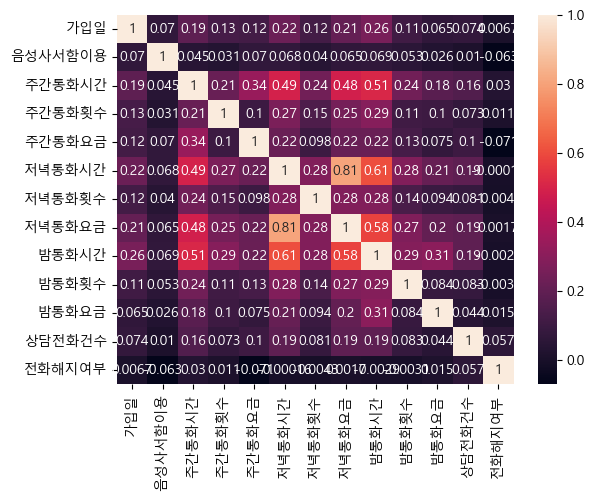

In [137]:
plt.rcParams['font.family'] = 'Malgun Gothic'
sns.heatmap(train.corr(), annot=True)   #저녁통화요금 & 저넉통화시간 상관계수가 높음 - 다중공선성 가능성

In [138]:
shownull(train)

데이터셋 차원 확인 
 (30200, 13)
결측값 있는 변수 확인 
 Series([], dtype: int64)


In [139]:
shownull(test)

데이터셋 차원 확인 
 (12943, 12)
결측값 있는 변수 확인 
 Series([], dtype: int64)


In [140]:
shownull(y_test)

데이터셋 차원 확인 
 (12943, 1)
결측값 있는 변수 확인 
 Series([], dtype: int64)


In [141]:
X_train = train.drop('전화해지여부', axis=1)
y_train = train['전화해지여부']

### ~~새로운 변수 생성~~

In [142]:
# ## 횟수가 0인데 시간, 요금이 0이상인 인스턴스가 있어 사용불가


# new_train = pd.DataFrame()
# new_test = pd.DataFrame()
# other_val = pd.DataFrame()

# def make_new_datasets(data, new_data):
#     for i in data.columns:
#         if '주간' in i:
#             day_time = data['주간통화시간'] / data['주간통화횟수']
#             day_charge = data['주간통화요금'] / data['주간통화횟수']
#             new_data['주간회당시간'], new_data['주간회당요금'] = day_time, day_charge
#         elif '저녁' in i:
#             evening_time = data['저녁통화시간'] / data['저녁통화횟수']
#             evening_charge = data['저녁통화시간'] / data['저녁통화횟수']
#             new_data['저녁회당시간'], new_data['저녁회당요금'] = evening_time, evening_charge
#         elif '밤' in i:
#             night_time = data['밤통화시간'] / data['밤통화횟수']
#             night_charge = data['밤통화시간'] / data['밤통화횟수']
#             new_data['밤회당시간'], new_data['밤회당요금'] = night_time, night_charge    
#         else:
#             new_data[i] = data[i]
#     print('---새로운 데이터셋 생성 완료---')

In [143]:
# make_new_datasets(X_train, new_train)
# make_new_datasets(test, new_test)

# X_train = new_train 
# X_train.fillna(0, inplace=True) # Train 데이터에 주간횟수가 0이라 NaN이 된 데이터가 있으므로 그 행에 해당되는 값을 0으로 처리
# X_test = new_test

In [144]:
new_train = pd.DataFrame()
new_test = pd.DataFrame()

def make_new_datasets2(data, new_data):
    for i in data.columns:
        if '시간' in i:
            daily_time = (data['주간통화시간'] + data['저녁통화시간'] + data['밤통화시간']) / data['가입일']
            new_data['일일통화시간'] = daily_time
            new_data[i] = data[i]
        elif '요금' in i:
            daily_charge = (data['주간통화요금'] + data['저녁통화요금'] + data['밤통화요금']) / data['가입일']
            new_data['일일통화요금'] = daily_charge
            new_data[i] = data[i]
        elif '횟수' in i:
            daily_count = (data['주간통화횟수'] + data['저녁통화횟수'] + data['밤통화횟수']) / data['가입일']
            new_data['일일통화횟수'] = daily_count
            new_data[i] = data[i]
        else:
            new_data[i] = data[i]
    print('---새로운 변수 생성 완료---')
    return

In [145]:
make_new_datasets2(X_train, new_train)
make_new_datasets2(test, new_test)

X_train = new_train 
X_test = new_test

---새로운 변수 생성 완료---
---새로운 변수 생성 완료---


In [146]:
X_test

,가입일,음성사서함이용,일일통화시간,주간통화시간,일일통화횟수,주간통화횟수,일일통화요금,주간통화요금,저녁통화시간,저녁통화횟수,저녁통화요금,밤통화시간,밤통화횟수,밤통화요금,상담전화건수
ID,,,,,,,,,,,,,,,
TEST_00000,110,0,4.886364,210.7,3.145455,142,0.530909,35.6,205.9,93,17.43,120.9,111,5.37,2
TEST_00001,283,1,2.973498,268.5,0.992933,100,0.238304,30.3,283.0,92,28.32,290.0,89,8.82,0
TEST_00002,34,1,16.517647,243.3,12.911765,205,1.551176,21.3,225.7,205,29.00,92.6,29,2.44,2
TEST_00003,209,86,2.968900,83.0,1.885167,93,0.238230,24.1,270.6,220,22.89,266.9,81,2.80,6
TEST_00004,202,0,4.014851,293.2,0.396040,23,0.317079,31.0,294.0,24,26.39,223.8,33,6.66,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TEST_12938,322,1,2.627950,282.4,2.621118,202,0.408634,89.9,270.2,321,32.80,293.6,321,8.88,2
TEST_12939,222,0,3.116667,233.5,2.265766,209,0.303829,34.6,234.0,92,23.22,224.4,202,9.63,2
TEST_12940,98,29,6.911224,223.4,6.326531,209,0.820204,29.3,223.9,203,28.82,230.0,208,22.26,2


### 이상치 탐색

#### IsolationForest

In [122]:
# #이상치 탐색

# isol_model = IsolationForest(n_estimators=100, contamination='auto', random_state=43)
# y_out = isol_model.fit_predict(X_train)
# x_train_out = X_train[y_out == -1]
# y_train_out = y_train[y_out == -1]

#### * 변수 중요도에 기반한 컬럼 일부 제거 *
(이전 모델 학습 후 다시 시행할 때 확인할 것)

In [147]:
# X_train = X_train.drop(['상담전화건수'], axis=1)
# test = test.drop(['상담전화건수'] , axis=1)

### 파일 분할

In [148]:
X_train0, X_val0, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=43)

### Scaling

In [149]:
#범주형변수 분리
cont_train = X_train0.drop('음성사서함이용', axis=1)
cont_val = X_val0.drop('음성사서함이용', axis=1)
cont_test = X_test.drop('음성사서함이용', axis=1)

In [150]:
cont_test.columns

Index(['가입일', '일일통화시간', '주간통화시간', '일일통화횟수', '주간통화횟수', '일일통화요금', '주간통화요금',
       '저녁통화시간', '저녁통화횟수', '저녁통화요금', '밤통화시간', '밤통화횟수', '밤통화요금', '상담전화건수'],
      dtype='object')

In [151]:
#스케일링
scaler = StandardScaler()
# scaler = MinMaxScaler()

X_train = X_train0.copy()
X_train[cont_train.columns] = scaler.fit_transform(cont_train)

X_val = X_val0.copy()
X_val[cont_val.columns] = scaler.transform(cont_val)

X_test = test.copy()
X_test[cont_test.columns]  = scaler.transform(cont_test)

### 클래스 불균형

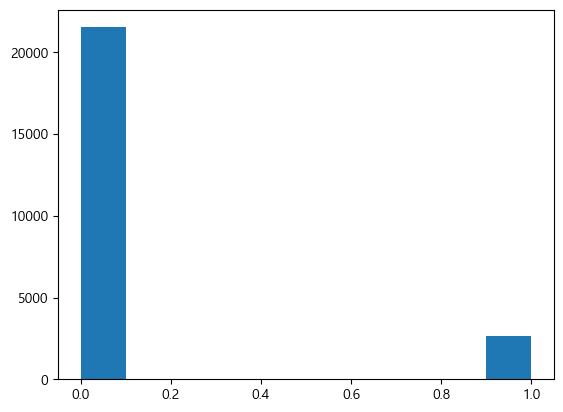

In [152]:
plt.hist(y_train)
plt.show()

#클래스 비대칭 해소해야 함 _ 전화 해지여부가 중요하므로 해지(1)에 더 높은가중치 부여

#### 가중치부여

In [153]:
counts = np.bincount(y_train) / len(y_train) #클래스별 개수 / 전체 개수
weights = 1.0 / counts #클래스별 가중치

sample_weights = np.zeros_like(y_train, dtype=np.float32) #각 샘플에 대해 가중치

#가중치 생성
for i, count in enumerate(counts):
    sample_weights[y_train == i] = weights[i]

In [154]:
sample_weights

array([1.1216341, 1.1216341, 1.1216341, ..., 1.1216341, 1.1216341,
       1.1216341], dtype=float32)

#### 언더 샘플링

In [155]:
# rus = RandomUnderSampler()
# X_train, y_train = rus.fit_resample(X_train, y_train)

## 차원 축소

### CPA

In [156]:
# pca = PCA()
# pca.fit(X_train)
# cumulative_var_ratio = np.cumsum(pca.explained_variance_ratio_)

# plt.plot(cumulative_var_ratio)
# plt.xlabel('Number of components')
# plt.ylabel('Cumulative explained variance ratio')
# plt.show()

# #전부 높으므로 일정량만 사용해서 하기로 결정

In [157]:
# pca = PCA(n_components=3) #3개 0.985 이하의 데이터 설명할 수 있음
# X_train_pca = pca.fit_transform(X_train)
# X_val_pca = pca.transform(X_val)
# X_test_pca = pca.transform(X_test)

## Light GBM

### 모든 변수

#### HyperOpt

In [158]:
# #LGBM 모델 정의
# def lgbm_student(params):
#     params = {
#         'boosting_type': 'dart',
#         'num_leaves' : int(params['num_leaves']),
#         'min_child_weight': int(params['min_child_weight']),
#         'learning_rate' : params['learning_rate'],
#         'max_depth': int(params['max_depth']),
#         'subsample': params['subsample']
#     }

#     clf = lgbm.LGBMClassifier(**params, n_estimators=1000, n_jobs=-1, random_state=43)
#     clf.fit(X_train_pca, y_train, eval_set=[(X_val_pca, y_val)], callbacks=[lgbm.log_evaluation()], sample_weight=sample_weights)  # //// lgbm.callback.early_stopping(10)

#     y_pred = clf.predict(X_val_pca)
#     score = Macro_f1(y_val, y_pred)
#     return {'loss':score, 'status': STATUS_OK, 'model': params}

In [159]:
# #하이퍼 파라미터 범위 설정
# space = {
#     'num_leaves' : hp.quniform('num_leaves', 10, 100, 1),
#     'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
#     'learning_rate' : hp.quniform('learning_rate', 0.001, 0.1, 0.001),
#     'max_depth': hp.quniform('max_depth', 1, 10, 1 ),
#     'subsample': hp.quniform('subsample', 0.6, 1, 0.05)
# }

#### Randomized Search

In [160]:
lgbm_param = {
    'boosting_type': ['dart'],
    'num_leaves' : list(range(10, 100, 1)),
    'min_child_weight': list(range(1, 10, 1)),
    'learning_rate' : list(np.arange(0.001, 0.1, 0.001)),
    'max_depth': list(range(1, 10, 1 )),
    'subsample': list(np.arange(0.6, 1, 0.05))
}

#### 학습

In [161]:
# ###########################
# #####     HyperOpt    #####
# ###########################

# # LGBM 하이퍼 파라미터 최적화 탐색

# trials = Trials()
# best = fmin(fn=lgbm_student,
#     space=space,
#     algo=tpe.suggest,
#     max_evals=50,
#     trials=trials
# )

# print(f"\n 최적의 하이퍼 파라미터: \n {best}")

In [162]:
# best['num_leaves'] = int(best['num_leaves'])
# best['min_child_weight'] = int(best['min_child_weight'])
# best['max_depth'] = int(best['max_depth'])

In [163]:
# lgbm_model = lgbm.LGBMClassifier(**best)
# lgbm_model.fit(X_train_pca, y_train, sample_weight=sample_weights)
# pred = lgbm_model.predict(X_test_pca)

In [164]:
###########################
##### Randmize Search #####
###########################

lgbm_grid = RandomizedSearchCV(
    estimator = lgbm.LGBMClassifier(n_estimators=10000, random_state=43),
    param_distributions=lgbm_param,
    n_jobs=-1,
    cv=3,
    refit=True,
    verbose=2,
    n_iter=50,
    random_state=43
    )
evaluation = [(X_train, y_train), (X_val, y_val)]
lgbm_grid.fit(X_train, y_train, eval_set=evaluation, sample_weight=sample_weights) #, sample_weight=sample_weights

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[1]	training's binary_logloss: 0.68548	valid_1's binary_logloss: 0.686013
[2]	training's binary_logloss: 0.68548	valid_1's binary_logloss: 0.686013
[3]	training's binary_logloss: 0.678235	valid_1's binary_logloss: 0.679462
[4]	training's binary_logloss: 0.678235	valid_1's binary_logloss: 0.679462
[5]	training's binary_logloss: 0.671518	valid_1's binary_logloss: 0.673215
[6]	training's binary_logloss: 0.665072	valid_1's binary_logloss: 0.66758
[7]	training's binary_logloss: 0.658987	valid_1's binary_logloss: 0.66217
[8]	training's binary_logloss: 0.659172	valid_1's binary_logloss: 0.66233
[9]	training's binary_logloss: 0.653083	valid_1's binary_logloss: 0.657319
[10]	training's binary_logloss: 0.647239	valid_1's binary_logloss: 0.652403
[11]	training's binary_logloss: 0.641675	valid_1's binary_logloss: 0.647767
[12]	training's binary_logloss: 0.636311	valid_1's binary_logloss: 0.64326
[13]	training's binary_logloss: 0.638262	

RandomizedSearchCV(cv=3,
                   estimator=LGBMClassifier(n_estimators=10000,
                                            random_state=43),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'boosting_type': ['dart'],
                                        'learning_rate': [0.001, 0.002, 0.003,
                                                          0.004, 0.005, 0.006,
                                                          0.007, 0.008,
                                                          0.009000000000000001,
                                                          0.010000000000000002,
                                                          0.011, 0.012,
                                                          0.013000000000000001,
                                                          0.014000000000000002,
                                                          0.015, 0.016, 0.017,
                                                          0.018000000000000002...
                                                          0.030000000000000002, ...],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8,
                                                      9],
                                        'min_child_weight': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9],
                                        'num_leaves': [10, 11, 12, 13, 14, 15,
                                                       16, 17, 18, 19, 20, 21,
                                                       22, 23, 24, 25, 26, 27,
                                                       28, 29, 30, 31, 32, 33,
                                                       34, 35, 36, 37, 38, 39, ...],
                                        'subsample': [0.6, 0.65,
                                                      0.7000000000000001,
                                                      0.7500000000000001,
                                                      0.8000000000000002,
                                                      0.8500000000000002,
                                                      0.9000000000000002,
                                                      0.9500000000000003]},
                   random_state=43, verbose=2)

In [165]:
lgbm_model = lgbm_grid.best_estimator_
lgbm_model.fit(X_train, y_train, sample_weight=sample_weights) #, sample_weight=sample_weights
pred = lgbm_model.predict(X_test)

In [166]:
feature_importances = lgbm_model.feature_importances_
feature_importances

array([23722, 15425, 26184, 47602, 33709, 42901, 27494, 49028, 45744,
       43082, 36509, 40317, 39935, 43290, 16668])

In [167]:
sorted_idx = np.argsort(feature_importances)
for i in sorted_idx:
    print(f'{pd.DataFrame(X_train).columns[i]}: {feature_importances[i]}')

음성사서함이용: 15425
상담전화건수: 16668
가입일: 23722
일일통화시간: 26184
일일통화요금: 27494
일일통화횟수: 33709
저녁통화요금: 36509
밤통화횟수: 39935
밤통화시간: 40317
주간통화횟수: 42901
저녁통화횟수: 43082
밤통화요금: 43290
저녁통화시간: 45744
주간통화시간: 47602
주간통화요금: 49028


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

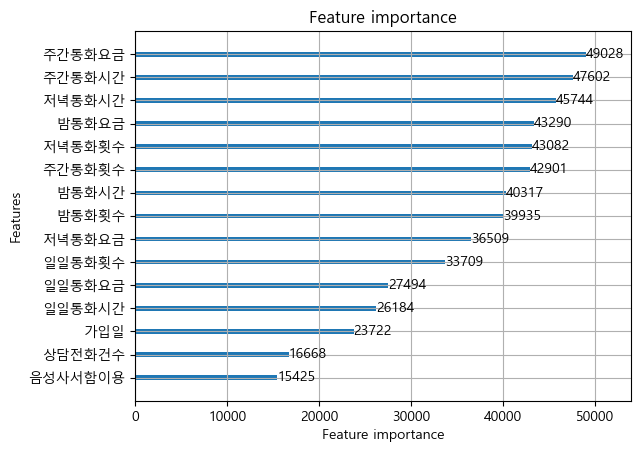

In [168]:
lgbm.plot_importance(lgbm_model)

In [169]:
submit = pd.read_csv("./sample_submission.csv")
submit.iloc[:,1] = pred
submit.to_csv('./submit_lgbm_18.csv', index=False)

In [170]:
submit

,ID,전화해지여부
0,TEST_00000,0
1,TEST_00001,0
2,TEST_00002,0
3,TEST_00003,0
4,TEST_00004,0
...,...,...
12938,TEST_12938,0
12939,TEST_12939,0
12940,TEST_12940,0
12941,TEST_12941,0
